In [47]:
catchment_name  = 'WykeBeck'

In [48]:
import geopandas as gpd
import rasterio
import pandas as pd
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from rasterio import plot
import earthpy.spatial as es
from rasterio.plot import plotting_extent
import earthpy.plot as ep

model_directory = '../../../FloodModelling/{}Models/'.format(catchment_name)

def find_area (fp, landcover_type):
    
    with rasterio.open(model_directory + fp, 'r') as ds:
        array = ds.read()  # read all raster values
    
    values, counts = np.unique(array, return_counts=True)
    df=pd.DataFrame({'values':values,'WholeCatchment': counts})
    pc = round((df['WholeCatchment'][0]/(df['WholeCatchment'][0] + df['WholeCatchment'][1])) *100,1)
    print("{}% of the catchment (with a landcover class) is {}".format(pc, landcover_type))

In [49]:
if catchment_name == 'LinDyke':
    catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/CatchmentLinDyke_exported.shp'.format(catchment_name))
elif catchment_name == 'WykeBeck':
    catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/WykeBeckCatchment.shp'.format(catchment_name))

### Find area of catchment

In [50]:
print("{} catchment has an area of {}km2".format(catchment_name, round((catchment_gdf['geometry'].area /10**6)[0],2)))

WykeBeck catchment has an area of 32.83km2


In [51]:
find_area ('LandCoverData/LandCover_urban_classification.tif', 'Urban')   

33.6% of the catchment (with a landcover class) is Urban


In [52]:
find_area('LandCoverData/LandCover_urban_and_suburban_classification.tif', 'Urban (including suburban)')

46.0% of the catchment (with a landcover class) is Urban (including suburban)


In [53]:
find_area('LandCoverData/LandCover_water_classification.tif', 'Water')

11.2% of the catchment (with a landcover class) is Water


In [54]:
find_area('LandCoverData/LandCover_notwater_classification.tif', 'not water')

88.8% of the catchment (with a landcover class) is not water


### Plot

In [15]:
colors_dict = {'clipped': ['darkslategrey', 'khaki', 'darkturquoise','darkgreen','#59F74D', 'slateblue', 'lightgreen', 'palegreen', 'pink'],
              'urban':['darkslategrey','lightgreen'], 'water':['blue','darkslategrey']}
labels_dict = {'clipped': ['SubUrban', 'Arable', 'Freshwater', 'Deciduous woodland', 'Improved grassland', 'Urban', 'Neutral grassland', 'Calcareous grassland', 'Heather grassland'],
              'urban':['Urban','Not urban'], 'water':['Water','Not water']}

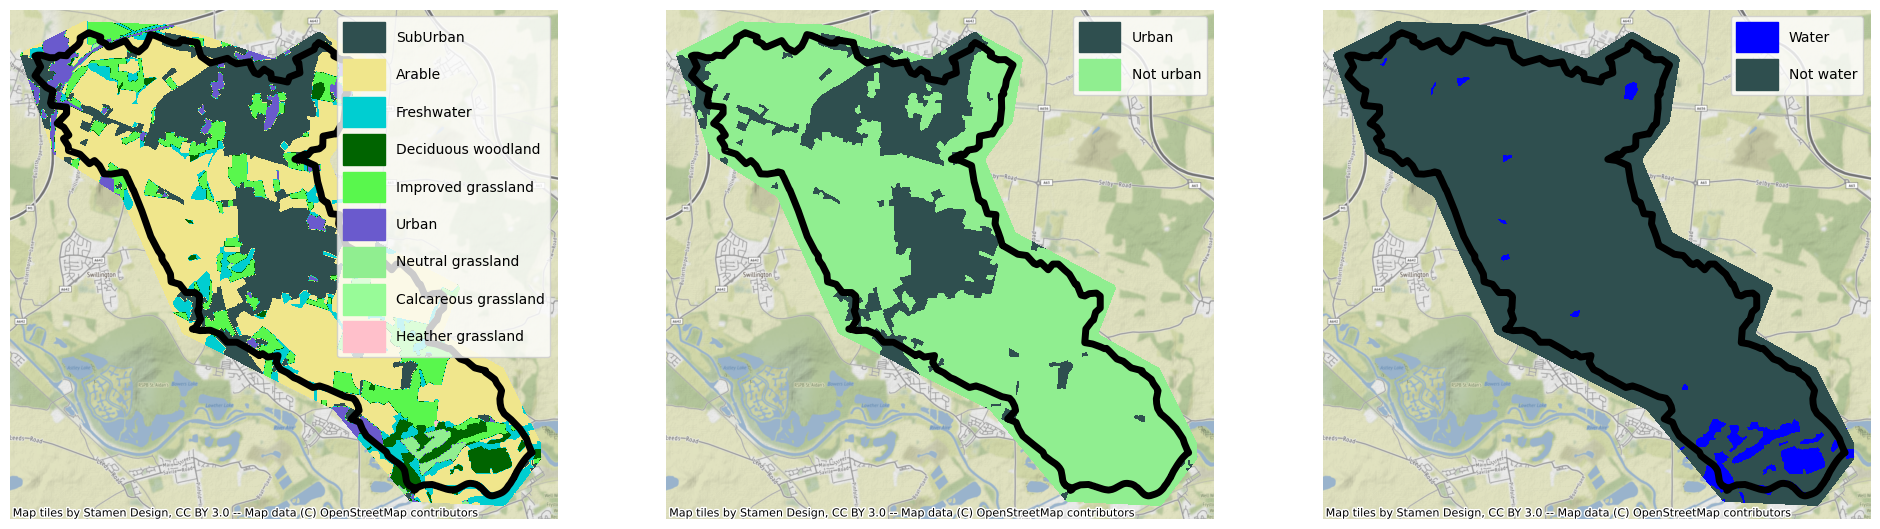

In [18]:
fig, axs = plt.subplots(ncols = 3, figsize=(24, 10))

def plot_land_cover(axs, fp, colors, labels):
    # Read in data
    array = rasterio.open(model_directory + fp)
    # PLot catchment boundary
    catchment_gdf.plot(ax=axs, facecolor="none", linewidth=5, edgecolor = 'black')
    # Add openstreetmap basemap
    cx.add_basemap(axs, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
    # plot
    plot.show((array, 1), ax= axs, cmap =mpl.colors.ListedColormap(colors))
    axs.axis('off')
    # Create legend
    patches_list = []
    for i, color in  enumerate(colors):
        patch =  mpatches.Patch(color=color, label=labels[i])
        patches_list.append(patch)  
    axs.legend(handles=patches_list, handleheight=3, handlelength=3, fontsize =10);

plot_land_cover(axs[0], 'LandCoverData/LandCover_clipped.tif', colors_dict['clipped'], labels_dict['clipped'])    
plot_land_cover(axs[1], 'LandCoverData/LandCover_urban_classification.tif', colors_dict['urban'], labels_dict['urban'])  
plot_land_cover(axs[2], 'LandCoverData/LandCover_water_classification.tif', colors_dict['water'], labels_dict['water'])    

### Plot topography

In [19]:
catchment_name  = 'LinDyke'
model_directory = '../../../FloodModelling/{}Models/'.format(catchment_name)
if catchment_name == 'LinDyke':
    catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/CatchmentLinDyke_exported.shp'.format(catchment_name))
elif catchment_name == 'WykeBeck':
    catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/WykeBeckCatchment.shp'.format(catchment_name))

In [20]:
watercourses = gpd.read_file('../../../FloodModelling/ExtraData/Watercourses/WatercourseLink.shp')

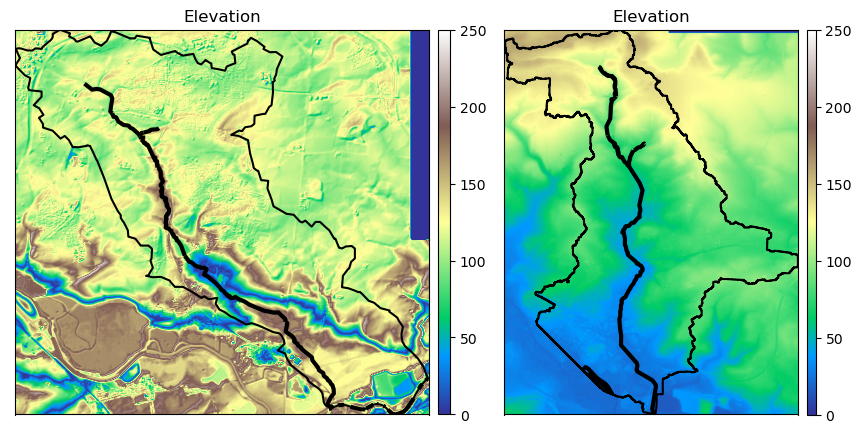

In [28]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,5 ), gridspec_kw={'wspace': -0.15})

def plot_topo(axs,fp, catchment_gdf):
    # Needed for cropping
    with rasterio.open(fp) as raster_crs:
        crop_raster_profile = raster_crs.profile
        crop_bound_utm13N = catchment_gdf.to_crs(crop_raster_profile["crs"])    
    
    # Read in data
    with rasterio.open(fp) as src:
        single_cropped_image, single_cropped_meta = es.crop_image(
        src, crop_bound_utm13N)
        
    # Create the extent object
    single_crop_extent = plotting_extent(single_cropped_image[0], single_cropped_meta["transform"])
        
    # Plot the newly cropped image
    crop_bound_utm13N.boundary.plot(ax=axs, color="black", zorder=10)
    if catchment_name == 'LinDyke':
        ep.plot_bands(single_cropped_image[0], ax=axs, extent=single_crop_extent, cmap = 'terrain', title="Elevation",
                      vmin=0,vmax=250)
    else:
        ep.plot_bands(single_cropped_image, ax=axs, extent=single_crop_extent, cmap = 'terrain', title="Elevation",
                                            vmin=0,vmax=250)
    
    watercourses_clip.plot(ax=axs, linewidth=3, color = 'black')    
    
# Plot Lin Dyke    
catchment_name  = 'LinDyke'
model_directory = '../../../FloodModelling/{}Models/'.format(catchment_name)
catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/CatchmentLinDyke_exported.shp'.format(catchment_name))
watercourses_clip = gpd.clip(watercourses, catchment_gdf)
plot_topo(axs[0], model_directory + 'TerrainData/terrain.tif', catchment_gdf)  

# Plot Wyke Beck
catchment_name  = 'WykeBeck'
model_directory = '../../../FloodModelling/{}Models/'.format(catchment_name)
catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/WykeBeckCatchment.shp'.format(catchment_name))
watercourses_clip = gpd.clip(watercourses, catchment_gdf)
plot_topo(axs[1], model_directory + 'Model_IdealisedProfiles/Terrain/Terrain.wykeDEM.tif', catchment_gdf) 

fig.savefig("../FigsForPaper/Terrain_BothCatchments.jpg",  bbox_inches='tight')

In [46]:
def plot_land_cover(axs, catchment_gdf, fp, colors, labels):
    # Read in data
    array = rasterio.open(fp)
    # PLot catchment boundary
    catchment_gdf.plot(ax=axs, facecolor="none", linewidth=5, edgecolor = 'black')
    # Add openstreetmap basemap
    cx.add_basemap(axs, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
    # plot
    plot.show((array, 1), ax= axs, cmap =mpl.colors.ListedColormap(colors))
    axs.axis('off')
    # Create legend
    patches_list = []
    for i, color in  enumerate(colors):
        patch =  mpatches.Patch(color=color, label=labels[i])
        patches_list.append(patch)  
    #axs.legend(handles=patches_list, handleheight=3, handlelength=3, fontsize =10);

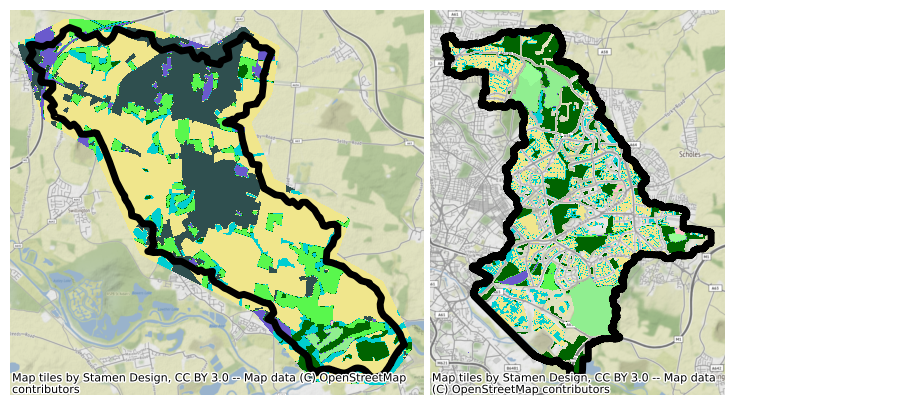

In [44]:
fig, axs = plt.subplots(ncols=2,figsize=(15, 5), gridspec_kw={'wspace': -0.55})

# Plot Lin Dyke    
catchment_name  = 'LinDyke'
model_directory = '../../../FloodModelling/{}Models/'.format(catchment_name)
catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/CatchmentLinDyke_exported.shp'.format(catchment_name))
watercourses_clip = gpd.clip(watercourses, catchment_gdf)
plot_land_cover(axs[0], catchment_gdf, model_directory + 'LandCoverData/LandCover_clipped.tif', colors_dict['clipped'], labels_dict['clipped'])    

# Plot Wyke Beck
catchment_name  = 'WykeBeck'
model_directory = '../../../FloodModelling/{}Models/'.format(catchment_name)
catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/WykeBeckCatchment.shp'.format(catchment_name))
watercourses_clip = gpd.clip(watercourses, catchment_gdf)
plot_land_cover(axs[1], catchment_gdf,  model_directory + 'LandCoverData/LandCover_clipped.tif', colors_dict['clipped'], labels_dict['clipped'])  

# fig.savefig("../FigsForPaper/Terrain_BothCatchments.jpg",  bbox_inches='tight')